In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn

import nibabel as nib
import os
import time
import gc
import copy

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:

class MedicalImageDataset(Dataset):
    def __init__(self, images_dir, masks_dir, target_size=(128, 128, 32), transform=None, num_classes=2):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.target_size = target_size
        self.transform = transform
        self.num_classes = num_classes
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii.gz')])
        self.mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith('.nii.gz')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        # Load the image and mask
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Convert to PyTorch tensors
        image = torch.from_numpy(image).unsqueeze(0).float()  # Adding channel dimension (1, H, W, D)
        mask = torch.from_numpy(mask).unsqueeze(0).long()  # Adding channel dimension (1, H, W, D)

        # Resize image and mask to target size using interpolation
        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=self.target_size, mode='nearest').squeeze(0).long()

        # Remove the channel dimension from the mask
        mask = mask.squeeze(0)  # Now the mask is of shape (H, W, D)

        # Clamp mask values to the range [0, num_classes - 1] to prevent out-of-bound errors
        mask = torch.clamp(mask, 0, self.num_classes - 1)

        if self.transform:
            image = self.transform(image)

        return image, mask


In [4]:

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool3d(2)
        
        self.bottleneck = conv_block(256, 512)
        
        self.upconv3 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv3d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.conv_last(dec1)


For run the code need to change te directories

In [5]:
images_dir = '/home/bdbotond/python/deep_learning/test/ASCENT/data/ACDC/raw/imagesTr'
masks_dir = '/home/bdbotond/python/deep_learning/test/ASCENT/data/ACDC/raw/labelsTr'

# Create the dataset and dataloader
full_dataset = MedicalImageDataset(images_dir, masks_dir)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])


train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader= DataLoader(val_dataset, batch_size=4, shuffle=True)

In [6]:
# Initialize the model, loss function, and optimizer
model = UNet(in_channels=1, out_channels=2)  # out_channels=2 for binary segmentation
loss_function = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.to(device)

UNet(
  (encoder1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool3d(kernel_size=2, stri

In [9]:
num_epochs =20

def train_model(model,loss_function,lr):
    model=model
    loss_function=loss_function
    optimizer=optim.Adam(model.parameters(), lr=lr)
    since=time.time()
    best_error=100
    #best_model=copy.deepcopy(model.state_dict())
    train_loss=[]
    val_loss=[]
    for epoch in range(num_epochs):
        model.train()
        running_loss=0
        for images, masks in train_dataloader:
            
            images=images.to(device)
            masks=masks.to(device)
            outputs = model(images)
            optimizer.zero_grad()
            loss = loss_function(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            #train_loss.append(loss.item())
        model.eval()
        validation_loss=0
        with torch.no_grad():
            for images,labels in val_dataloader:
                images=images.to(device)
                labels=labels.to(device)
                output_val=model(images)
                val_loss=loss_function(output_val,labels)
                validation_loss += val_loss.item()

                #val_loss.append(val_loss)
        
        b_loss=validation_loss/len(val_dataloader)
        if b_loss<=best_error:
                best_error=b_loss
                best_epoch=epoch
                print(best_error,best_epoch)
                best_model=copy.deepcopy(model.state_dict())
                torch.save(best_model,'./u_net_test_e20_'+str(lr)+'.pt')
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_dataloader)},Validation Loss: {validation_loss/len(val_dataloader)}")

        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()

    time_elapsed=time.time()-since
    print(f"Training time was:[{time_elapsed}]")

In [10]:
train_model(model,loss_function,1e-4)

0.26420623660087583 0
Epoch [1/20], Training Loss: 0.3288604557514191,Validation Loss: 0.26420623660087583
0.21525366157293319 1
Epoch [2/20], Training Loss: 0.2214403498917818,Validation Loss: 0.21525366157293319
0.17633098214864731 2
Epoch [3/20], Training Loss: 0.1881618745625019,Validation Loss: 0.17633098214864731
0.17104361653327943 3
Epoch [4/20], Training Loss: 0.17359874583780766,Validation Loss: 0.17104361653327943
0.1532336488366127 4
Epoch [5/20], Training Loss: 0.15290051698684692,Validation Loss: 0.1532336488366127
Epoch [6/20], Training Loss: 0.13882257360965014,Validation Loss: 0.15353810489177705
0.1268606260418892 6
Epoch [7/20], Training Loss: 0.13230133168399333,Validation Loss: 0.1268606260418892
0.12229397743940354 7
Epoch [8/20], Training Loss: 0.12038897965103387,Validation Loss: 0.12229397743940354
0.11233218684792519 8
Epoch [9/20], Training Loss: 0.11284356527030467,Validation Loss: 0.11233218684792519
0.1071006752550602 9
Epoch [10/20], Training Loss: 0.1044

In [11]:

def plot_data(tensor,batch_index):
    batch_index = batch_index  # Select the first element in the batch
    channel_index = 1  # Select the first channel
    
    # Extract the specific batch and channel
    data = tensor[batch_index, channel_index]  # Shape: [128, 128, 32]
    
    # Plot a few slices from this data
    num_slices_to_plot = 5  # Number of slices to visualize
    slice_indices = torch.linspace(0, data.shape[2] - 1, num_slices_to_plot).long()  # Select slices evenly
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, num_slices_to_plot, i + 1)
        plt.imshow(data[:, :, idx], cmap='gray')
        plt.title(f"Slice {idx.item()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_mask(tensor,batch_index):
    batch_index = batch_index  # Select the first element in the batch
    #channel_index = 0  # Select the first channel
    
    # Extract the specific batch and channel
    data = tensor[batch_index]  # Shape: [128, 128, 32]
    
    # Plot a few slices from this data
    num_slices_to_plot = 5  # Number of slices to visualize
    slice_indices = torch.linspace(0, data.shape[2] - 1, num_slices_to_plot).long()  # Select slices evenly
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, num_slices_to_plot, i + 1)
        plt.imshow(data[:, :, idx], cmap='gray')
        plt.title(f"Slice {idx.item()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
model = UNet(in_channels=1, out_channels=2)  # out_channels=2 for binary segmentation
loss_function = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.load_state_dict(torch.load('./u_net_test_e20_0.0001.pt',weights_only=True))
model.to(device)
model.eval()
print('Model is loadad for testing')

Model is loadad for testing


In [15]:
test_images_dir = '/home/bdbotond/python/deep_learning/test/ASCENT/data/ACDC/raw/imagesTs'
test_masks_dir = '/home/bdbotond/python/deep_learning/test/ASCENT/data/ACDC/raw/labelsTs'
test_dataset = MedicalImageDataset(test_images_dir, test_masks_dir)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)


Original, Mask type: 1


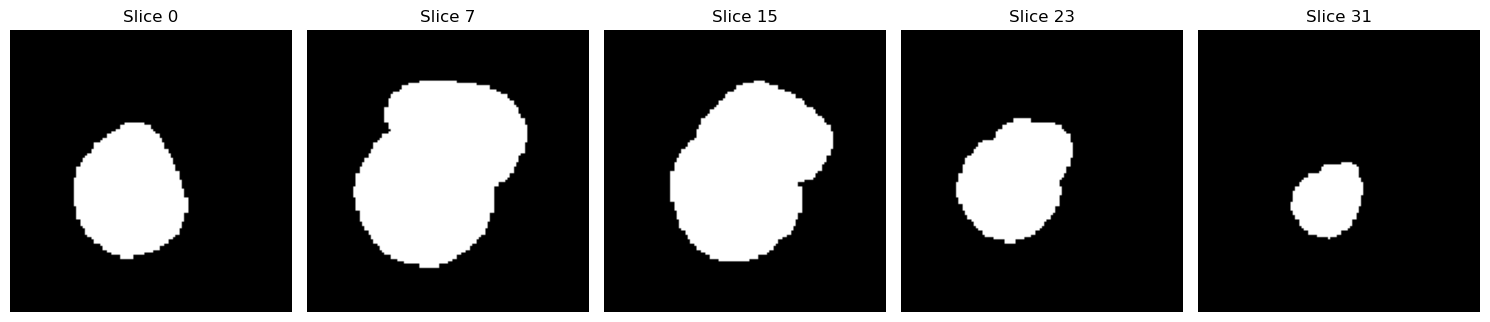

Predict


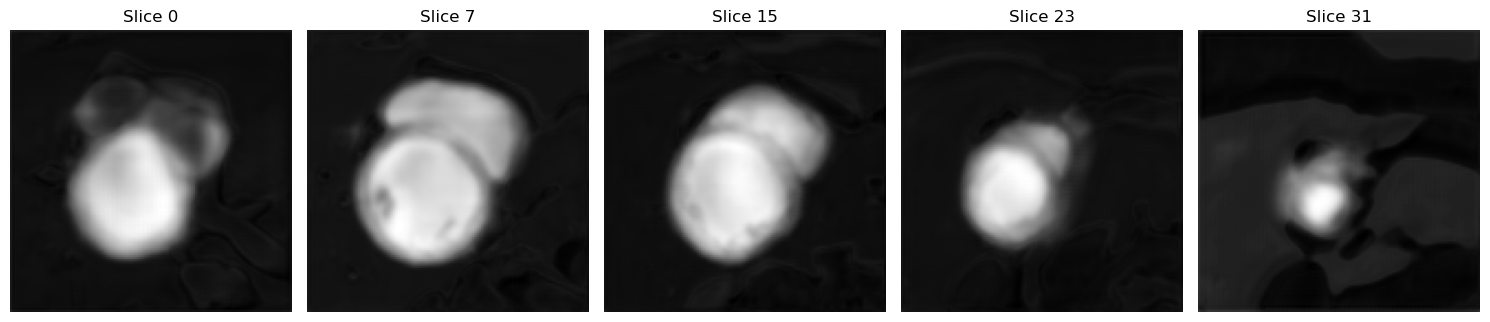

Original, Mask type: 2


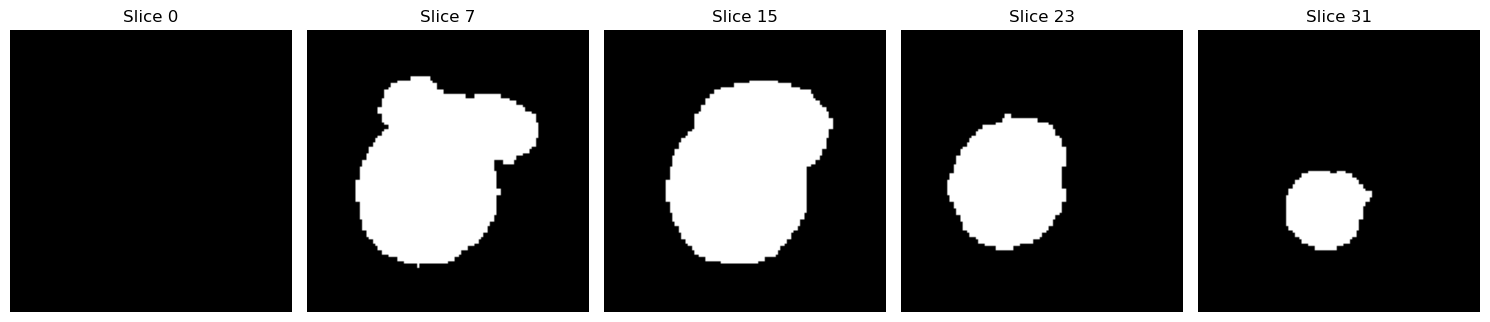

Predict


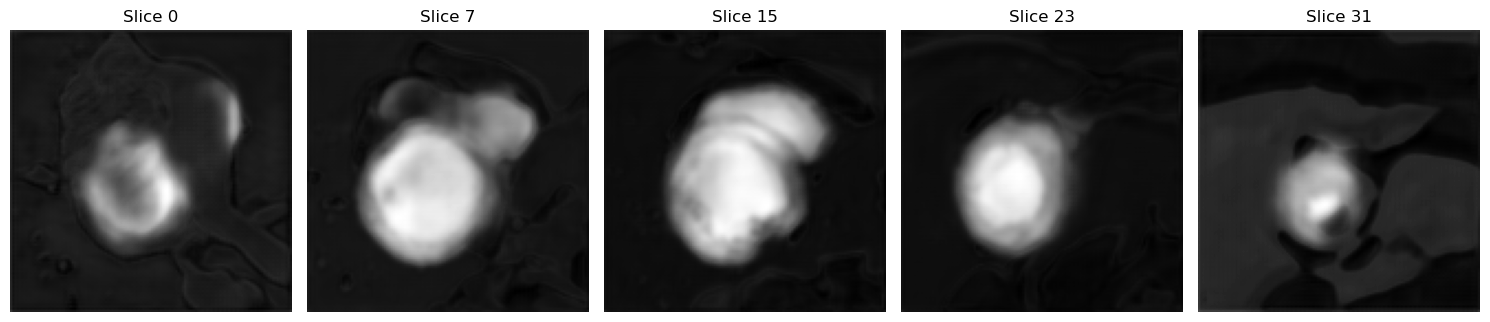

Original, Mask type: 3


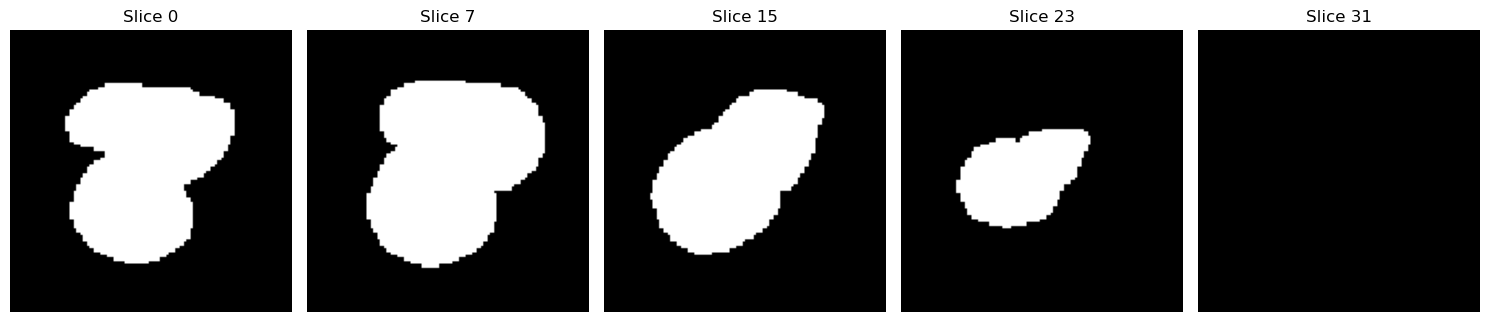

Predict


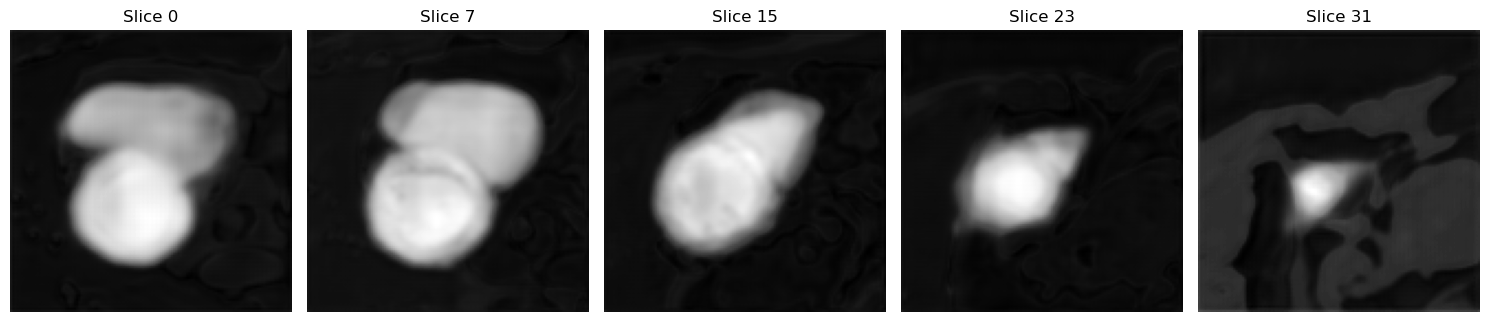

Validation Loss: 0.0068186295821386226


In [19]:
val_loss = 0.0
data=[]
i=0
for n in range(0,3):
    for images, masks in test_dataloader:
        #plot_data(images,n)
        images=images.to(device)
        masks=masks.to(device)        
        outputs = model(images)
        loss = loss_function(outputs, masks)
        print('Original, Mask type:', n+1)
        plot_mask(masks.detach().cpu(),n)
        print('Predict')
        plot_data(outputs.detach().cpu(),n)
        data.append(outputs.detach().cpu().numpy())
        val_loss += loss.item()
        i=i+1
        if i>0:
            break
        
print(f"Validation Loss: {val_loss/len(test_dataloader)}")


In [22]:
val_loss = 0.0

for images, masks in test_dataloader:
    #plot_data(images,n)
    images=images.to(device)
    masks=masks.to(device)        
    outputs = model(images)
    loss = loss_function(outputs, masks)
    val_loss += loss.item()

print(f"Validation Loss on the unseen test set: {val_loss/len(test_dataloader)}")


Validation Loss on the unseen test set: 0.08639635079923798
